In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno    # 누락값 표시
import warnings
warnings.filterwarnings('ignore')  # 워닝 무시

# 새로운 창 안 뜨고 노트북에 바로 뜸
%matplotlib inline 

## 데이터 전처리

### Wanted

In [4]:
data_wanted = pd.read_csv('./data/data_wanted.csv', encoding='euc-kr')

In [5]:
# Location에서 '.한국' 제거

data_wanted1 = data_wanted
data_wanted1["Location"] = list(map(lambda i: i.replace(".한국", ""), data_wanted["Location"]))

In [ ]:
# Position keyword 확인
from collections import Counter

arr = [i.split() for i in data_wanted1.Position]

keywords = [j for i in arr for j in i]

# Counter(keywords)
list(data_wanted1.Position)

In [7]:
# Position 키워드에 따라 데이터 drop

keywords = ['프론트', '프런트', '백', '앤드', '엔드', '풀', '스택', '웹', 'Front', 'Back', 'end',
            'S/W', 'Software', 'SW', '소프트웨어', 'React', 'Python', 'Java'] 
            
mask = data_wanted1['Position'].str.contains('|'.join(keywords), case = False)

filtered_data = data_wanted1[mask]

In [8]:
# 'Skill' 채우기 : 'Position' 값에서 추출

# 'Position'에서 키워드 선정 
filtered_data[filtered_data["Skill"].isna()].Position

keywords = {'C++':"C", 'JS':"Java Script", 'Python':"Python", 'Node':"Node.js", 'React':"React"}

mask = filtered_data[filtered_data["Skill"].isna()]

for i in mask["Position"]:
    for j in keywords.keys():
        if j.casefold() in i.casefold():
            mask.loc[mask["Position"] == i, "Skill"] = keywords[j]

filtered_data.loc[filtered_data["Skill"].isna(), "Skill"] = mask["Skill"]

In [ ]:
# 'Skill' 채우기 후 NaN 값 확인
for col in filtered_data:
    msg = 'column: {:>10}\t Number of NaN value: {:.0f}'.format(col, filtered_data[col].isnull().sum())
    print(msg)

filtered_data[filtered_data["Skill"].isna()]

# Skill이 NaN인 row drop
filtered_data = filtered_data.drop(index=filtered_data[filtered_data['Skill'].isna()].index, axis=1)

In [11]:
# 'Position' [풀스택, 서버/백엔드, 프론트엔드]로 분류
filtered_data1 = filtered_data

list(filtered_data1.Position)
keywords = {'프론트':'프론트엔드', '프런트':'프론트엔드', 'Front':'프론트엔드', '백':'서버/백엔드',
            'Back':'서버/백엔드', 'Full':'풀스택', '풀':'풀스택', '웹':'풀스택'}
position = filtered_data1.Position
for i in keywords.keys():
    position = list(map(lambda j: keywords[i] if i in j else j, position))

filtered_data1['Position'] = position

filtered_data1 = filtered_data1[filtered_data1['Position'].isin(['프론트엔드', '서버/백엔드', '풀스택'])]

### Programmers

In [12]:
data_programmers = pd.read_csv('./data/data_programmers.csv', encoding='euc-kr')

In [13]:
# 'Location' 정리
data_programmers1 = data_programmers
keywords = ['서울', '경기', '부산', '대전', '대구']
location = data_programmers1.Location
for i in keywords:
    location = list(map(lambda j: i if i in j else j, location))

data_programmers1.Location = location

In [ ]:
# 'Skill'  NaN 값 확인
for col in data_programmers1:
    msg = 'column: {:>10}\t Number of NaN value: {:.0f}'.format(col, data_programmers1[col].isnull().sum())
    print(msg)

data_programmers1[data_programmers1["Skill"].isna()]

# Skill이 NaN인 row drop(15 rows)
data_programmers1 = data_programmers1.drop(index=data_programmers1[data_programmers1['Skill'].isna()].index, axis=1)

In [15]:
# 'Position' [웹 풀스택, 서버/백엔드, 프론트엔드]로 분류
arr = list(map(lambda j: j[0], map(lambda i: i.split(), data_programmers.Position)))
arr = list(map(lambda i: i.replace("웹", "풀스택"), arr))

data_programmers1 = data_programmers
data_programmers1['Position'] = arr

### 전처리 완료한 데이터(wanted, programmers) 합치기

In [34]:
all_done_wanted = filtered_data1
all_done_programmers = data_programmers1

In [ ]:
# Merge the dataframes while excluding entries with the same company
merged_data = pd.concat([all_done_wanted, all_done_programmers]).drop_duplicates(subset='Company')

# Reset the index
merged_data.reset_index(drop=True, inplace=True)

merged_data

## 데이터 시각화

In [18]:
# 한글 안 깨지게 설정 

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
# 포지션별 공고 갯수
group_position = dict(merged_data["Company"].groupby(merged_data["Position"]).count())
print(group_position)

In [ ]:
# 지역별 공고 갯수
group_loc = dict(merged_data["Company"].groupby(merged_data["Location"]).count())
print(group_loc)

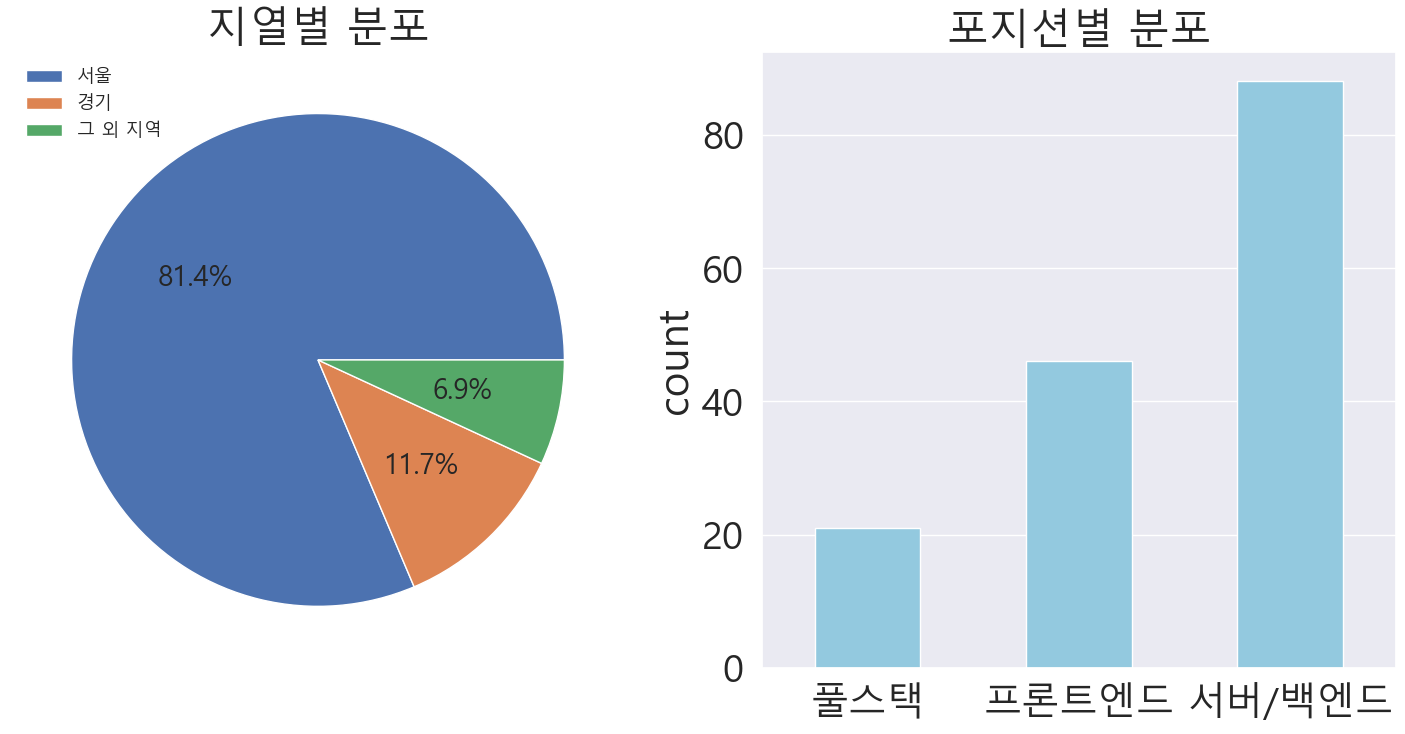

In [21]:
location = {'서울': 118, '경기': 17, '그 외 지역': 10}
f,ax=plt.subplots(1,2, figsize=(18,8))
ax[0].pie(location.values(), autopct='%1.1f%%', textprops={'size': 20})
sns.countplot(x='Position', data=merged_data, color='skyblue', width=0.5, ax=ax[1])

ax[0].legend(location.keys(), loc='upper left', prop={'size': 13})
ax[0].set_title("지열별 분포")
ax[1].set_title("포지션별 분포")
ax[1].set_xlabel("")
plt.show()

In [45]:
def get_skill(data):
    skill = []
    for i in data.Skill:
        temp = i.replace('[', '').replace(']', '').split(",")
        for j in temp:
            skill += [j.strip()]

    counter = Counter(skill)

    # 값이 10 이상인 것만 추출
    filtered_skill = {key: value for key, value in counter.items() if value >= 20}

    return filtered_skill

# 전체 기술스택(val >= 20)
skill_total = get_skill(merged_data)

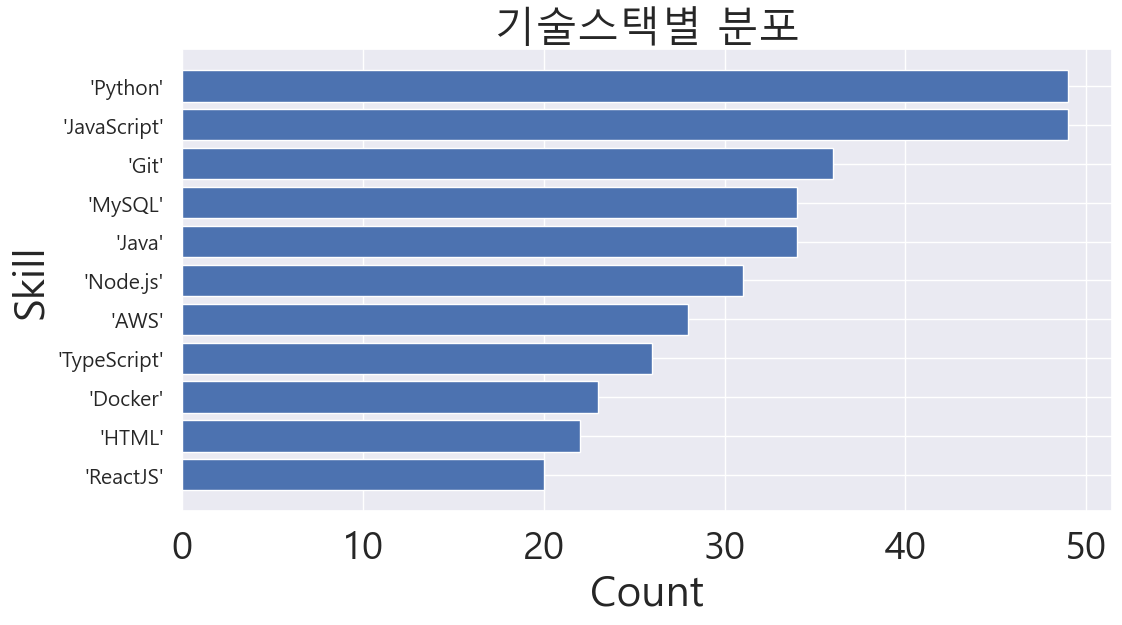

In [46]:
data = dict(sorted(skill_total.items(), key = lambda item: item[1]))
plt.figure(figsize=(12, 6))
plt.barh(list(data.keys()), data.values())
plt.xlabel('Count')
plt.ylabel('Skill')
plt.yticks(fontsize=15)
plt.title('기술스택별 분포')
plt.show()